**Implementacion de funciones**

In [19]:
# Librerias
import numpy as np
import scipy.io 
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene  
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import adfuller

In [35]:
# Metricas
def metrics(signal):
    mean = np.mean(signal)
    rms = np.sqrt(np.mean(np.square(signal)))
    var = np.var(signal)
    std = np.std(signal)
    return mean, rms, var, std

def supuestos(senal1, senal2, s='ciclo a', d='ciclo b'):
    """Funcion que permite identificar si una señal cumple con los supuestos de:"
    Normalidad, Homocedasticidad
    """
    s1, p1 = shapiro(senal1)
    s2, p2 = shapiro(senal2)
    s_l, p_l = levene(senal1, senal2)
    if p1 > 0.05 and p2 > 0.05 and p_l > 0.05:
        return f"""No se rechaza la hipotesis nula, igualdad de varianzas
        p {s}: {p1}
        p {d}: {p2}
        p Levene: {p_l}"""
    elif p1 > 0.05 and p2 > 0.05 and p_l < 0.05:
        return f"""Cumplen normalidad, no homocedasticidad
        p {s}: {p1}
        p {d}: {p2}
        p Levene: {p_l}"""
    else:
        s_u, p_u = mannwhitneyu(senal1, senal2)
        if p_u < 0.05:
            return f"""Se realiza la prueba no parametrica U de Mann-Whitney, Hay diferencia estadistica
            p {s}: {p1}
            p {d}: {p2}
            p Levene: {p_l}"""
        else:
            return f"""Se realiza la prueba no parametrica U de Mann-Whitney, no hay diferencia significativa
            p {s}: {p1}
            p {d}: {p2}
            p Levene: {p_l}"""



 **Analisis estadistico**

In [21]:
# signals.mat
signals = scipy.io.loadmat("signals.mat")
signals

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Apr 20 15:20:29 2015',
 '__version__': '1.0',
 '__globals__': [],
 'Fs': array([[1024]], dtype=uint16),
 'ECG_asRecording': array([[3904.31689453, 3939.203125  , 3976.00683594, ..., 4366.41064453,
         4365.31103516, 4370.91796875]], shape=(1, 30720)),
 'ECG_filtered': array([[ 8.87103896e-03,  5.62737497e+01,  8.57077127e+01, ...,
         -1.20952610e+02, -1.31734356e+02, -1.32898021e+02]],
       shape=(1, 30720)),
 'EMG_filtered1': array([[ 17.65905117,  19.41391578,  18.89666666, ..., 242.49414224,
         220.4135886 , 151.5810508 ]], shape=(1, 30721)),
 'EMG_filtered2': array([[  21.1780547 ,  -79.82418538, -133.65960989, ..., -384.58994036,
         -539.9349533 , -772.65519631]], shape=(1, 30721)),
 'EMG_asRecording1': array([[ 908.07531738,  903.17706299,  896.62982178, ..., 1433.91882324,
         1416.109375  , 1352.75012207]], shape=(1, 30721)),
 'EMG_asRecording2': array([[-3109.97558594, -3231.

In [22]:
# Tiempo de duración
# frecuencia de muestreo = 1024Hz -> 1024 muestras cada segundo -> 1/1024 periodo de muestreo
Fm = 1024                                       # Frecuencia de muestreo
Tm = 1 / Fm
dimentions = signals['ECG_asRecording'].shape 
time = dimentions[1] * Tm
time                                            # Segundos

30.0

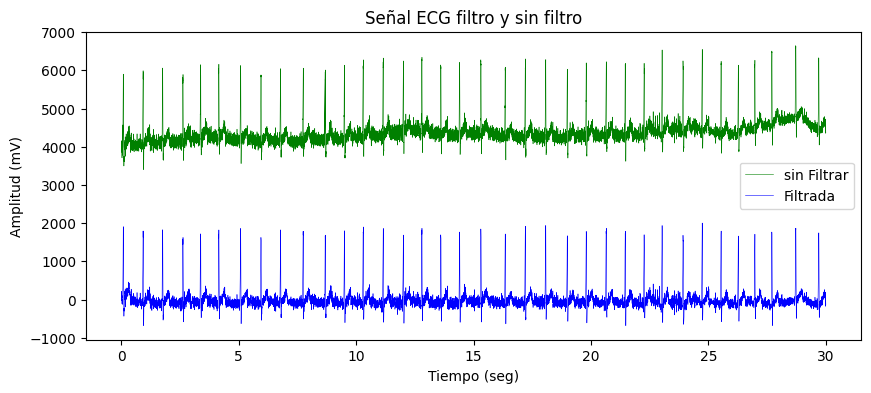

In [41]:
# Grafica señal filtrada, sin filtrar
y_nofilter = signals['ECG_asRecording'][0]
y_filter = signals['ECG_filtered'][0]

# Crear array con el tiempo
t = np.arange(0, time, Tm)

plt.figure( figsize= (10, 4) )
plt.plot(t, y_nofilter, color= 'green', label= 'sin Filtrar', linewidth= 0.4)
plt.plot(t, y_filter, color= 'blue', label= 'Filtrada', linewidth= 0.4)
plt.title('Señal ECG filtro y sin filtro')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')
plt.legend()
plt.savefig('Senal_ECG_filtro_y_sin_filtro')
plt.show()

**Sin Filtro:** Se observa que la gráfica se encuentra desplazada a aproximadamente 4000mV, esto puede deberse a la interfaz entre el electrodo y el electrolito, que genera un potencial electrico debido a las reacciones electroquimicas, este potencial aparece como un voltaje DC que se suma a la señal util. Tambien puede deberse a las corrientes "bias currents" que necesitan los amplificadores para funcionar, estas corrientes pueden fluir a traves de la impedancia de la piel con el electrodo, generando asi un voltaje que puede añadirse como offset de igual manera a la señal. 

**Con Filtro:** Se quita le offset generado por el ruido para un analisis posterior mas adecuado

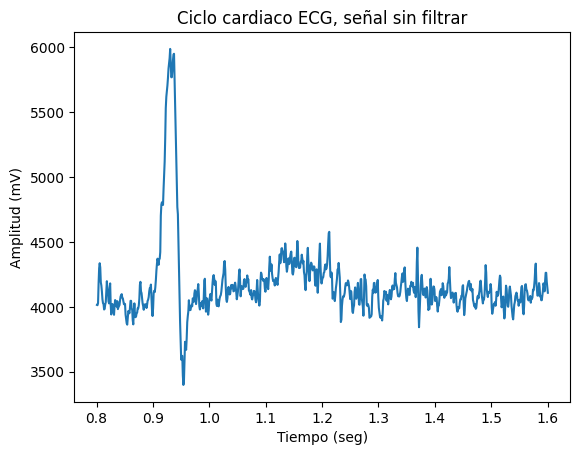

In [42]:
# Señal sin filtrar - Ciclo cardiaco
position_ = np.where(t ==  Tm * 820)                      # Aprox 0.8 seg -> 0.8/Tm = 820 aprox
t_cycle = t[position_[0][0]:position_[0][0]*2]
y_cycle = y_nofilter[position_[0][0]:position_[0][0]*2]   # Se multiplica por 2 para ver el segundo ciclo y tener mas informacion

plt.plot(t_cycle, y_cycle)
plt.title('Ciclo cardiaco ECG, señal sin filtrar')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')
plt.savefig('Ciclo cardiaxo 1')
plt.show()

valor RMS: 4181.72
valor varianza: 89986.54


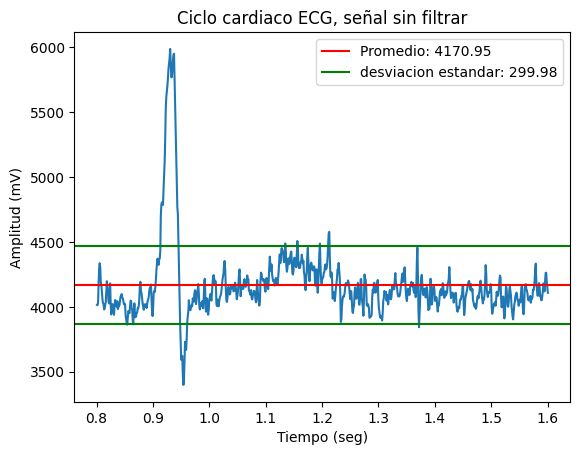

In [43]:
# Calculo del promedio, varianza, desviacion estandar, valor RMS
mean_noFilter, rms__noFilter, var_noFilter, desviation__noFilter = metrics(y_cycle)
print(f"valor RMS: {round(rms__noFilter, 2)}\nvalor varianza: {round(var_noFilter, 2)}")

# grafico
plt.plot(t_cycle, y_cycle)
plt.title('Ciclo cardiaco ECG, señal sin filtrar')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')

# lineas de promedio, desviacion estandar
plt.axhline(y= mean_noFilter, color= 'red', label= f'Promedio: {round(mean_noFilter, 2)}')
plt.axhline(y= mean_noFilter + desviation__noFilter, color= 'green', label= f'desviacion estandar: {round(desviation__noFilter, 2)}')
plt.axhline(y= mean_noFilter - desviation__noFilter, color= 'green')

plt.legend()

plt.savefig('Ciclo_cardiaco_1_metricas')

plt.show()

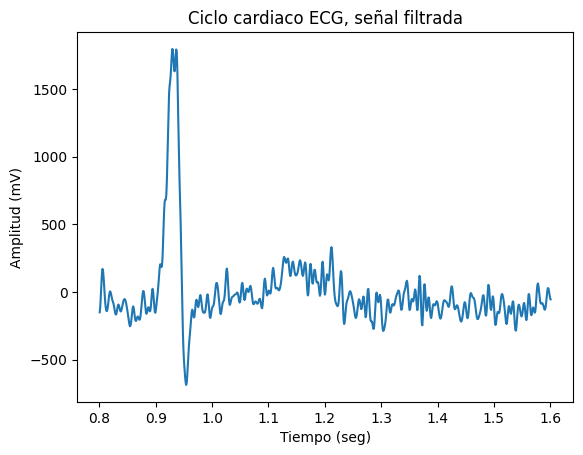

In [44]:
# Señal filtrada - Ciclo cardiaco
position_ = np.where(t ==  Tm * 820)                     # Aprox 0.8 seg -> 0.8/Tm = 820 aprox
t_cycle_ = t[position_[0][0]:position_[0][0]*2]
y_cycle_ = y_filter[position_[0][0]:position_[0][0]*2]   # Se multiplica por 2 para ver el segundo ciclo y tener mas informacion

plt.plot(t_cycle_, y_cycle_)
plt.title('Ciclo cardiaco ECG, señal filtrada')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')
plt.savefig('Ciclo cardiaco2')
plt.show()

valor RMS: 301.14
valor varianza: 90654.57


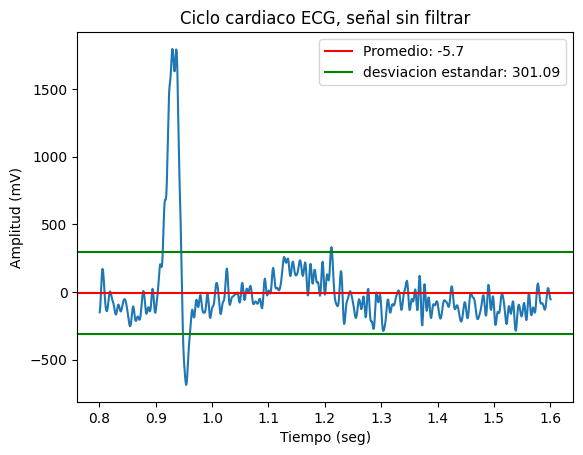

In [45]:
# Calculo del promedio, varianza, desviacion estandar, valor RMS
mean_Filter, rms__Filter, var_Filter, desviation__Filter = metrics(y_cycle_)
print(f"valor RMS: {round(rms__Filter, 2)}\nvalor varianza: {round(var_Filter, 2)}")

# grafico
plt.plot(t_cycle, y_cycle_)
plt.title('Ciclo cardiaco ECG, señal sin filtrar')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')

# lineas de promedio, desviacion estandar
plt.axhline(y= mean_Filter, color= 'red', label= f'Promedio: {round(mean_Filter, 2)}')
plt.axhline(y= mean_Filter + desviation__Filter, color= 'green', label= f'desviacion estandar: {round(desviation__Filter, 2)}')
plt.axhline(y= mean_Filter - desviation__Filter, color= 'green')

plt.legend()

plt.savefig('Ciclo CArdiaco 2 Metricas')

plt.show()

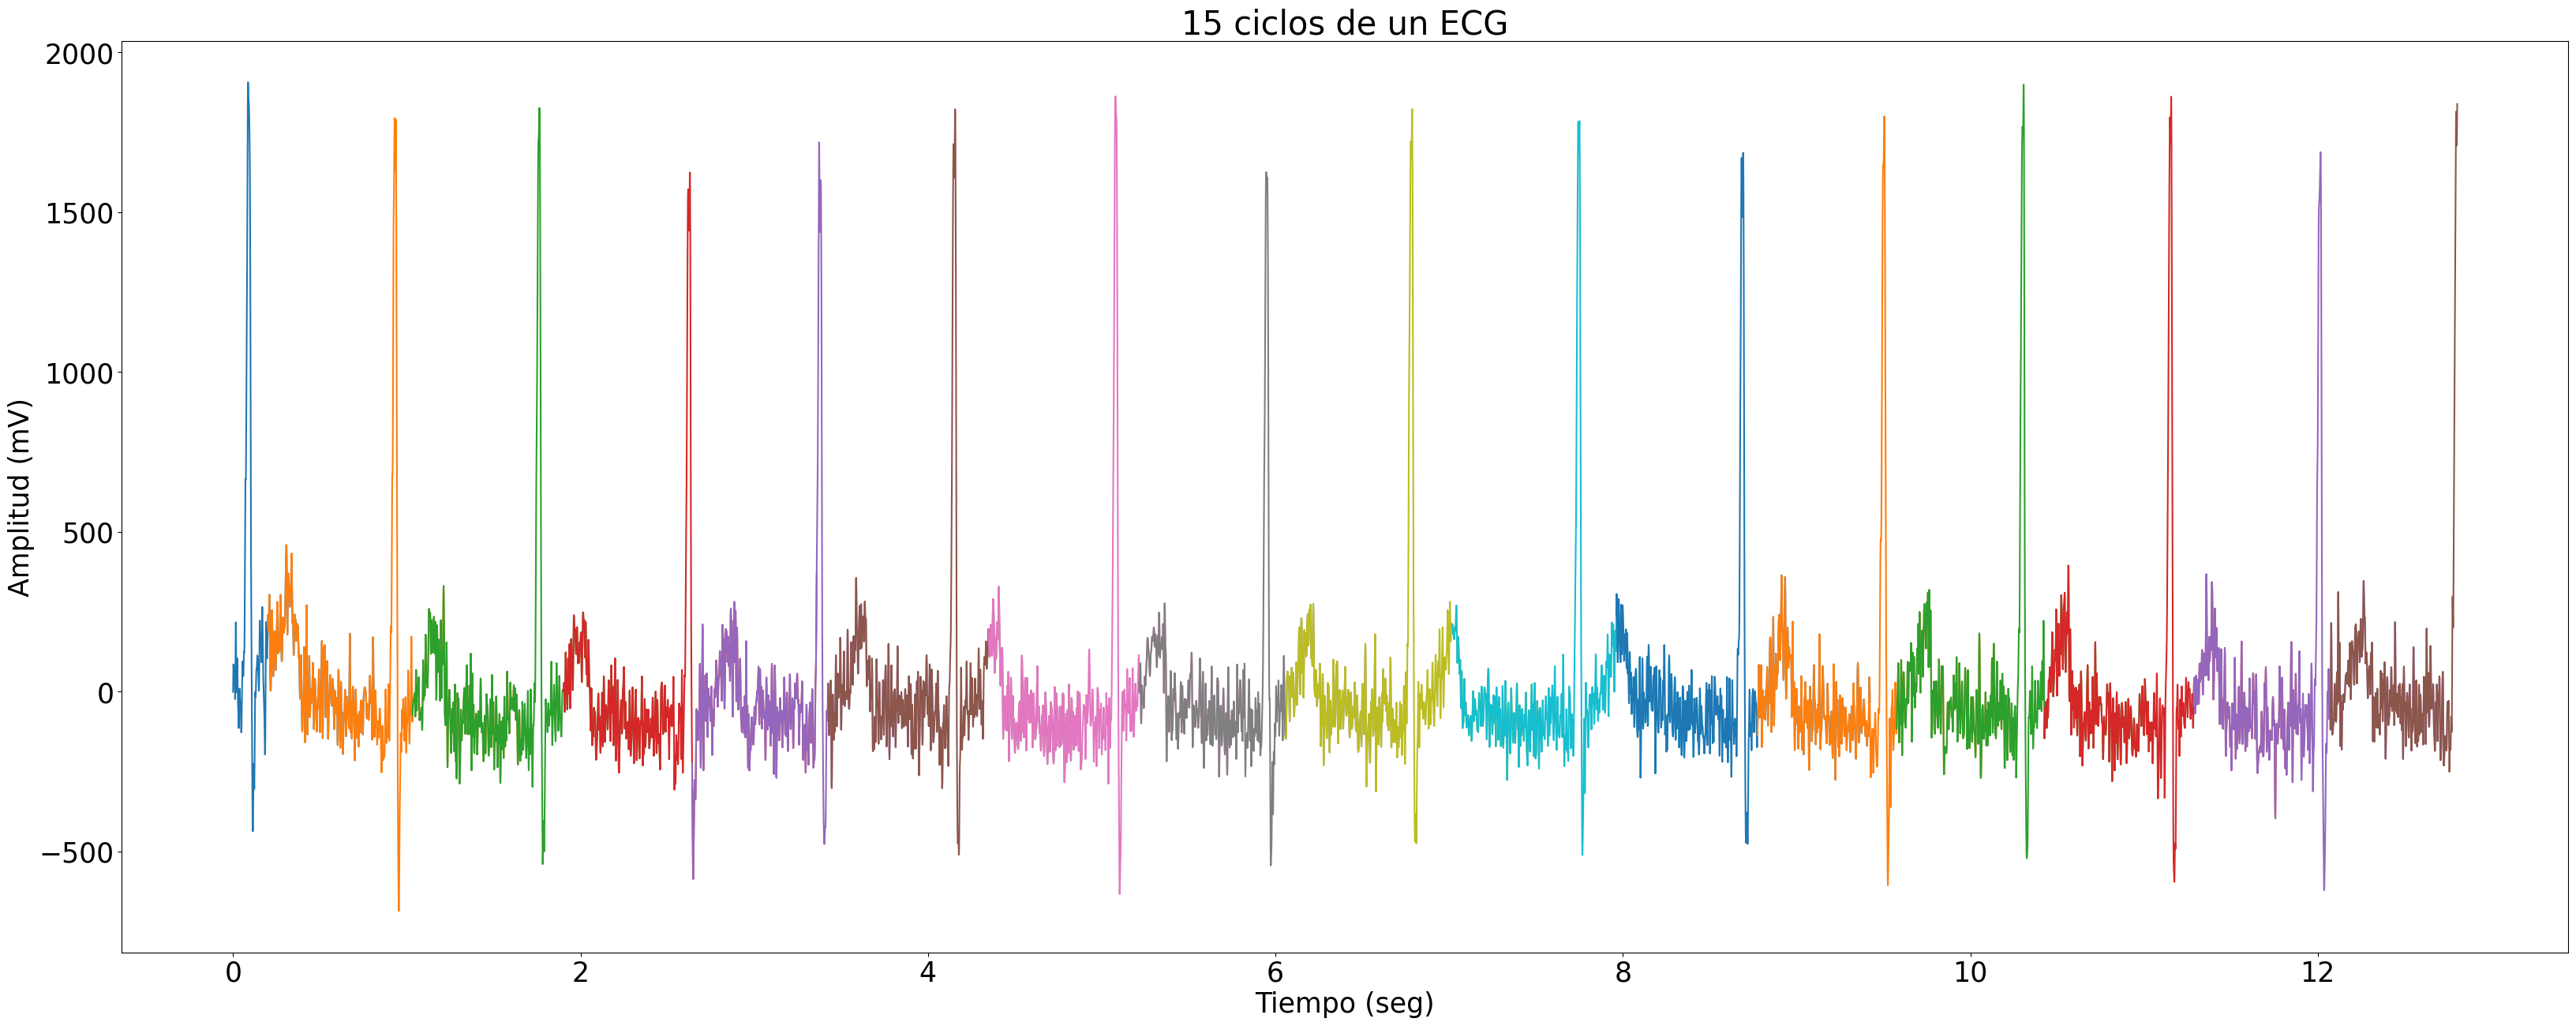

In [46]:
# Señal filtrada - 15 ciclos 
distance = 0.3 * Fm                                     # distancia entre picos      
height = np.mean(y_filter) + np.std(y_filter)           # Picos que detectara + arriba de la media y desviacion estandar positiva

peaks, _ = find_peaks( y_filter, height= height, distance= distance )
cycle_15_position = peaks[0:16][15]                     # Se toma la posicion del pico 16 en este caso para que muestre 15 ciclos completos

t_15_cycle = t[0:cycle_15_position]
y_15_cycle = y_filter[0:cycle_15_position]


# Obtencion de los 15 ciclos
cycles = []                                             # Almacena los ciclos

peaks_15 = peaks[0:16]                                  # Se toman los 15 primeros picos

lenght_15 = len( peaks[0:16] )                          # Longitud lista de los 15 primeros picos

dif = np.diff( peaks[0:16] )                            # Diferencia entre picos consecutivos: con el objetivo de conocer la cantidad de muestras entre dos picos consecutivos
ave_window = int( np.mean(dif) - (2*np.std(dif)) )      # Se calcula el numero de muestras aproximado en base a dif, ademas se resta su desviacion estandar * 2 para evitar que se toman dos picos como un ciclo

# Guardar cada ciclo
for i in range(lenght_15):
    start = max( peaks_15[i] - ave_window, 0 )          # max, garantiza que en caso de ser la primera muestra no me muestre valores negativos, pues de ser asi muestra el 0
    end = min(peaks_15[i] + ave_window, len(y_15_cycle))# min, garantiza que en caso de ser la ultima muestra no se pase de los valores del array

    cycle = y_filter[start:end]
    time_cycle = t[start:end]

    cycles.append( [time_cycle, cycle] )


# Graficar
plt.figure(figsize=(40,15))

for i in cycles:
    plt.plot( i[0], i[1] )


plt.title( "15 ciclos de un ECG", fontsize= 30 )
plt.ylabel( "Amplitud (mV)", fontsize= 25 )
plt.xlabel( "Tiempo (seg)", fontsize= 25 )
plt.tick_params(axis='both', labelsize=25)
plt.savefig('Ciclos')
plt.show()

Varianza ciclo 1: 95682.25
Varianza ciclo 2: 58749.28
Varianza ciclo 3: 53662.13
Varianza ciclo 4: 48077.26
Varianza ciclo 5: 50541.2
Varianza ciclo 6: 54623.53
Varianza ciclo 7: 55651.05
Varianza ciclo 8: 46036.24
Varianza ciclo 9: 52454.77
Varianza ciclo 10: 51577.23
Varianza ciclo 11: 47872.05
Varianza ciclo 12: 51287.63
Varianza ciclo 13: 56519.52
Varianza ciclo 14: 57915.07
Varianza ciclo 15: 49902.19


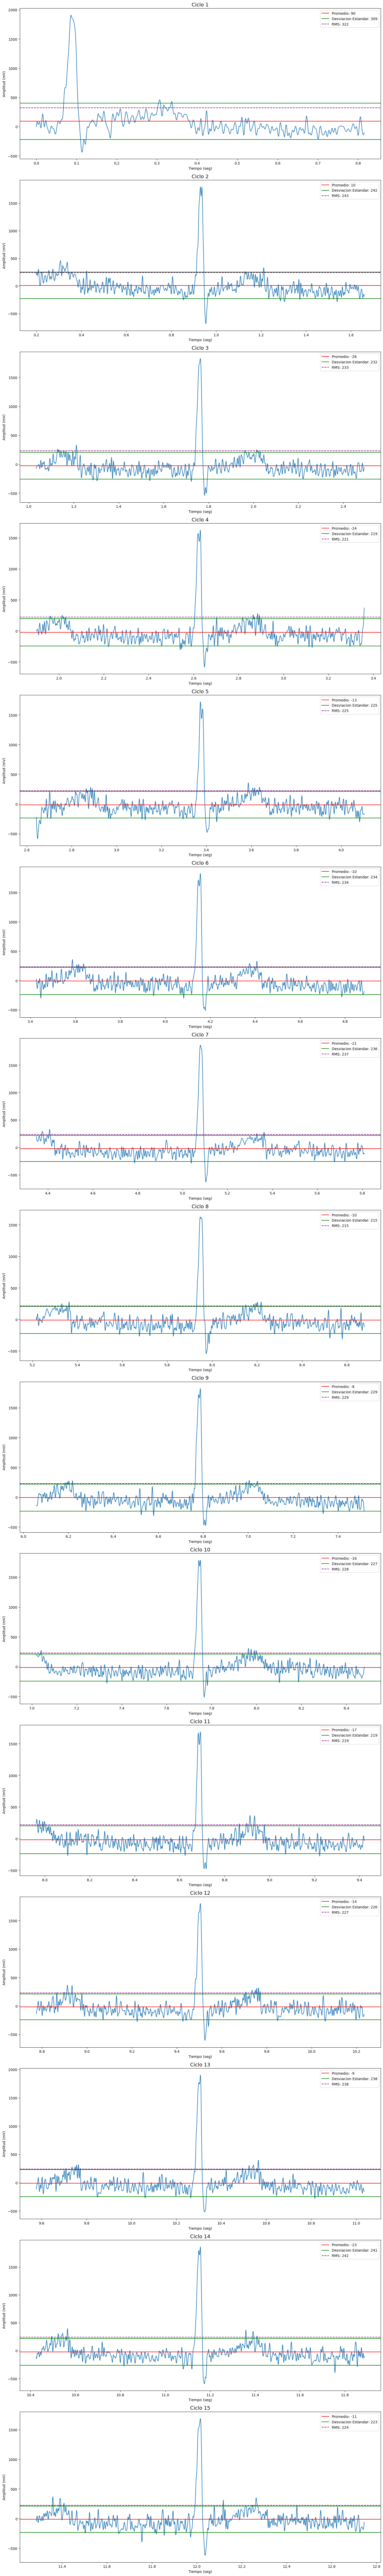

In [47]:
# Grafico 2 de los 15 ciclos
num_plots = len( cycles ) - 1                                           # Para saber cuantos graficos hay que hacer
fig, axes = plt.subplots(num_plots, 1, figsize=(15, 100))  

m = {}                                                                  # creacion de diccionario para guardar las metricas de los ciclos (para ver despues en graficos)

for cont, ciclo in enumerate(cycles[:15]):
    axes[cont].plot( ciclo[0], ciclo[1] )
    axes[cont].set_title(f'Ciclo {cont + 1}', fontsize=14)

    mean_c, rms_c, var_c, std_c = metrics( ciclo[1] )
    axes[cont].axhline( mean_c, color= 'red', label= f'Promedio: {round( mean_c )}')
    axes[cont].axhline( mean_c + std_c, color= 'green', label= f'Desviacion Estandar: {round( std_c )}' )
    axes[cont].axhline( mean_c - std_c, color= 'green' )
    axes[cont].axhline( rms_c, color= 'purple', label= f'RMS: {round( rms_c )}', linestyle= '--' )
    axes[cont].legend()
    axes[cont].set_xlabel('Tiempo (seg)')
    axes[cont].set_ylabel('Amplitud (mV)')
    print(f'Varianza ciclo {cont + 1}: {round(var_c, 2)}')
    
    m[f'ciclo {cont + 1}'] = [mean_c, rms_c, var_c, std_c]              

plt.savefig('ciclos_metricas')
plt.tight_layout()
plt.show()

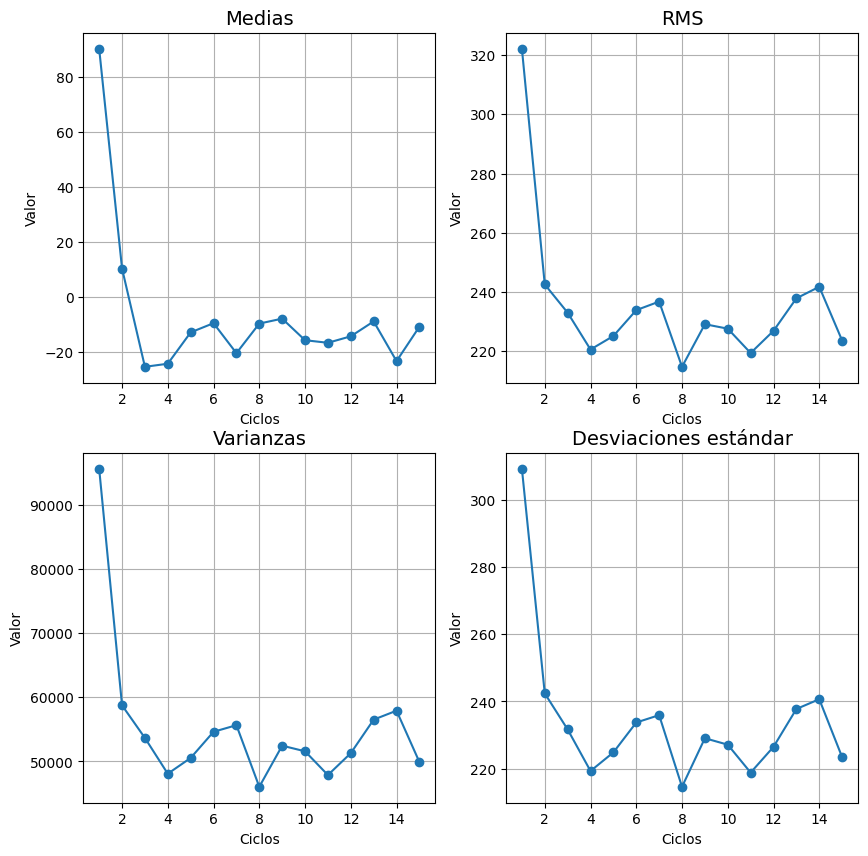

In [48]:
# Grafica metricas de los 15 ciclos
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  

c = [i + 1 for i in range (15)]             # ciclos
v = [m[v][2] for v in m]                    # varianzas
me = [m[v][0] for v in m]                   # Medias
r = [m[v][1] for v in m]                    # RMS
s = [m[v][3] for v in m]                    # desviaciones estandar

metricas = [me, r, v, s]
titulos = ['Medias', 'RMS', 'Varianzas', 'Desviaciones estándar']

# Graficar cada métrica en su subplot correspondiente
for i in range(4):
    fila = i // 2
    columna = i % 2
    axes[fila, columna].plot(c, metricas[i], marker='o')
    axes[fila, columna].set_title(titulos[i], fontsize=14)
    axes[fila, columna].set_xlabel('Ciclos')
    axes[fila, columna].set_ylabel('Valor')
    axes[fila, columna].grid()

plt.savefig('metricas_15_ciclos')

    

In [37]:
# Prueba t
cycle_1 = cycles[1][1]
cycle_2 = cycles[2][1]
cycle_3 = cycles[3][1]
cycle_4 = cycles[4][1]

# hipotesis
# Ho : Distribucion normal               - Las varianzas de las poblaciones son iguales 
# Ha : No siguen una distribucion normal - Las varianzas no son iguales

'Se realiza la prueba no parametrica U de Mann-Whitney, Hay diferencia estadistica\n            p ciclo a: 4.615385843631485e-48\n            p ciclo b: 3.7843882313323255e-51\n            p Levene: 0.035227971478652295'

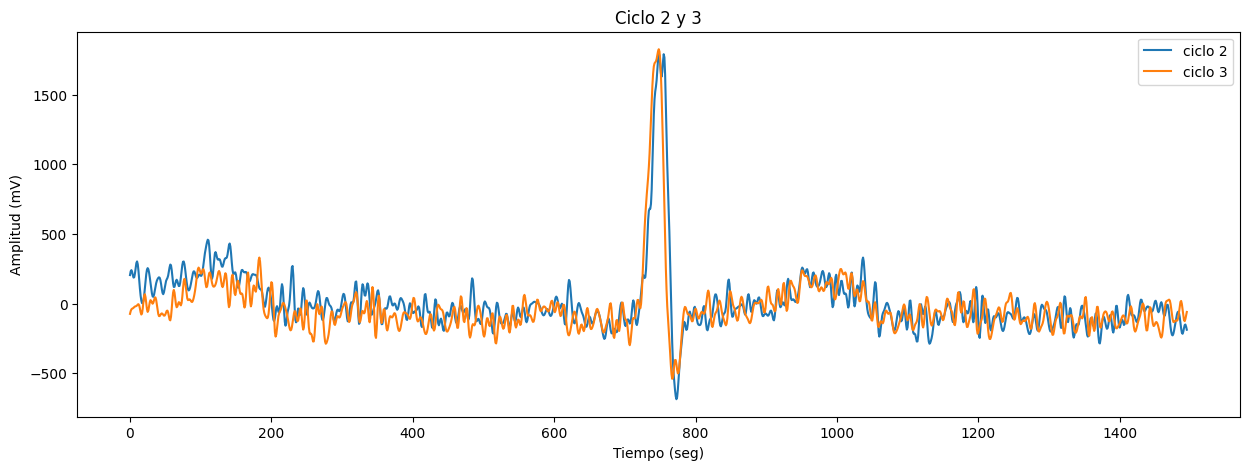

In [49]:
# Prueba 1 - entre ciclo 2 y 3
t_comun = np.arange(0, len(cycle_1)) 

plt.figure(figsize= (15,5))
plt.plot(t_comun, cycle_1, label= 'ciclo 2') 
plt.plot(t_comun, cycle_2, label= 'ciclo 3')
plt.title('Ciclo 2 y 3')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')
plt.legend()
plt.savefig('prueba_ciclo1_ciclo2')

p_1 = supuestos(cycle_1, cycle_2)
p_1

'Se realiza la prueba no parametrica U de Mann-Whitney, Hay diferencia estadistica\n            p ciclo a: 8.043725881132788e-50\n            p ciclo b: 6.500832753108969e-49\n            p Levene: 0.6400744104222795'

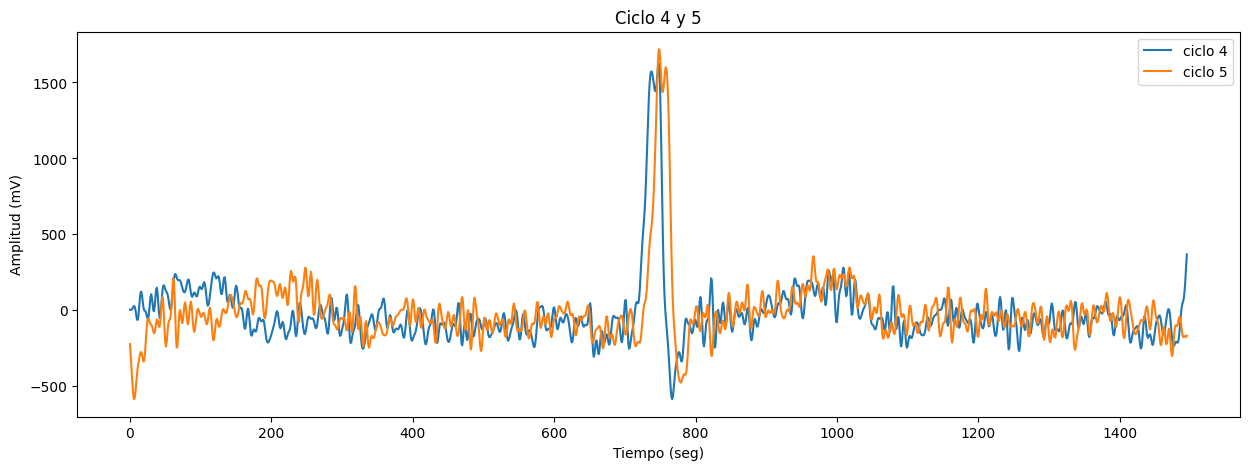

In [50]:
# Prueba 2 - entre ciclo 4 y 5
plt.figure(figsize= (15,5))
plt.plot(t_comun, cycle_3, label= 'ciclo 4') 
plt.plot(t_comun, cycle_4, label= 'ciclo 5')
plt.title('Ciclo 4 y 5')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud (mV)')
plt.legend()

p_2 = supuestos(cycle_3, cycle_4)
plt.savefig('Pruebaciclo4_ciclo5')
p_2

In [40]:
# Comprobacion de Estacionariedad para la señal filtrada
r_1 = adfuller( y_filter )

x = "Estacionaria" if r_1[1] < 0.05 else "No estacionaria"
x

'Estacionaria'